In [90]:
import requests
import shutil
import os
import io
import json
import time
import datetime
import dateutil
import re
import numpy as np
import pandas as pd
from IPython.display import clear_output
from pprint import pprint
import matplotlib.pyplot as plt

parent_folder='steam_data'

csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
csv_english_folder=os.path.join(parent_folder,"bulk","csv_english","early_access_standardized")
testing_folder=os.path.join(parent_folder,"bulk","testing")

In [141]:
with open(os.path.join(testing_folder,'still_in_early_access_FINAL'),'r') as file:
    current_ea_games=sorted(list(set([int(x) for x in file.read().split('\n')[:-1]])))
with open(os.path.join(testing_folder,'out_of_early_access_FINAL'),'r') as file:
    former_ea_games=sorted(list(set([int(x) for x in file.read().split('\n')[:-1]])))
full_games_list=sorted(list(set(current_ea_games+former_ea_games)))
with open(os.path.join(parent_folder,'official_appid_json_list'),'r') as file:
    temp_json=json.load(file)['applist']['apps']
official_app_list={}
for x in temp_json:
    official_app_list[x['appid']]=x['name']
print(len(full_games_list))

4935


In [143]:
num_reviews={}

In [146]:
csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
out_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

for i,appid in enumerate(current_ea_games,1):
    temp_time_series=[]
    df=pd.read_csv(os.path.join(csv_folder,str(appid)+'_reviews_all.csv'))
    num_reviews[int(appid)]=len(df)
    earliest_time=df['timestamp_updated'].min()
    latest_time=df['timestamp_updated'].max()
    num_months=int(np.ceil(float(latest_time-earliest_time)/(30.0*24.0*60.0*60.0)))
    for j in range(num_months):
        num_pos=float(len(df[(df['timestamp_updated']>=earliest_time+(j)*30.0*24.0*60.0*60.0) &
                    (df['timestamp_updated']<earliest_time+(j+1)*30.0*24.0*60.0*60.0) &
                      (df['voted_up']==True)]))
        num_neg=float(len(df[(df['timestamp_updated']>=earliest_time+(j)*30.0*24.0*60.0*60.0) &
                    (df['timestamp_updated']<earliest_time+(j+1)*30.0*24.0*60.0*60.0) &
                      (df['voted_up']==False)]))
        if num_neg>0 or num_pos>0:
            temp_time_series.append({'early_access':True,'month':j,'reviews':int(num_pos+num_neg),'ratio':num_pos/(num_neg+num_pos)})
    pd.DataFrame(temp_time_series).to_csv(os.path.join(out_folder,str(appid)+'_month_time_series.csv'))
    clear_output(wait=True)
    print(str(i)+"/"+str(len(current_ea_games)))

2939/2939


In [219]:
csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
out_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

early_access_exit_time={}
normal_review_start_time={}
time_midpoint={}

for i,appid in enumerate(former_ea_games,1):
    temp_time_series=[]
    df=pd.read_csv(os.path.join(csv_folder,str(appid)+'_reviews_all.csv'))
    if len(df[df['written_during_early_access']==True])>0:
        num_reviews[int(appid)]=len(df)
        early_access_exit_time[int(appid)]=df[df['written_during_early_access']==True]['timestamp_updated'].max()
        earliest_time=df['timestamp_updated'].min()
        latest_time=df['timestamp_updated'].max()
        #print(len(df[df['written_during_early_access']==True]))
        if(len(df[df['written_during_early_access']==False]))>0:
            normal_review_start_time[int(appid)]=df[df['written_during_early_access']==False]['timestamp_updated'].min()
            midpoint=(early_access_exit_time[int(appid)]+normal_review_start_time[int(appid)])/2
            num_months_after=int(np.ceil(float(latest_time-midpoint)/(30.0*24.0*60.0*60.0)))
        else:
            midpoint=early_access_exit_time[int(appid)]+60
            num_months_after=0
        time_midpoint[int(appid)]=midpoint
        #print(appid)
        #print(float(early_access_exit_time[int(appid)]))
        #print(float(normal_review_start_time[int(appid)]))
        num_months_before=int(np.ceil(float(time_midpoint[int(appid)]-earliest_time)/(30.0*24.0*60.0*60.0)))
        for j in range(num_months_before):
            num_pos=float(len(df[(df['timestamp_updated']>=midpoint-(num_months_before-j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint-(num_months_before-(j+1))*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==True)]))
            num_neg=float(len(df[(df['timestamp_updated']>=midpoint-(num_months_before-j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint-(num_months_before-(j+1))*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==False)]))
            if num_neg>0 or num_pos>0:
                temp_time_series.append({'early_access':True,'month':j,'reviews':int(num_pos+num_neg),'ratio':num_pos/(num_neg+num_pos)})
        for j in range(num_months_after):
            num_pos=float(len(df[(df['timestamp_updated']>=midpoint+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint+(j+1)*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==True)]))
            num_neg=float(len(df[(df['timestamp_updated']>=midpoint+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint+(j+1)*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==False)]))
            if num_neg>0 or num_pos>0:
                temp_time_series.append({'early_access':False,'month':num_months_before+j,'reviews':int(num_pos+num_neg),'ratio':num_pos/(num_neg+num_pos)})
        pd.DataFrame(temp_time_series).to_csv(os.path.join(out_folder,str(appid)+'_month_time_series.csv'))
    clear_output(wait=True)
    print(str(i)+"/"+str(len(former_ea_games)))

1996/1996


In [380]:
csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

useful_examples={}

for i,appid in enumerate(former_ea_games,1):
    temp_time_series=[]
    df=pd.read_csv(os.path.join(csv_folder,str(appid)+'_reviews_all.csv'))
    if len(df[df['written_during_early_access']==True])>0 and len(df[df['written_during_early_access']==False])>0:
            useful_examples[appid]={}
            useful_examples[appid]['num_edited_from_early_access']=df['edited_from_early_access'].sum()
            if len(df[df['edited_from_early_access']==True])>0:
                useful_examples[appid]['ratio_edited_positive']=df[df['edited_from_early_access']==True]['voted_up'].sum()/float(len(df[df['edited_from_early_access']==True]))
            else:
                useful_examples[appid]['ratio_edited_positive']=0.5
            midpoint=time_midpoint[appid]
            for j in range(12):
                num_pos=float(len(df[(df['timestamp_updated']>=midpoint+(j)*30.0*24.0*60.0*60.0) &
                            (df['timestamp_updated']<midpoint+(j+1)*30.0*24.0*60.0*60.0) &
                              (df['voted_up']==True)]))
                num_neg=float(len(df[(df['timestamp_updated']>=midpoint+(j)*30.0*24.0*60.0*60.0) &
                            (df['timestamp_updated']<midpoint+(j+1)*30.0*24.0*60.0*60.0) &
                              (df['voted_up']==False)]))
                if num_pos+num_neg>10:
                    break       
            useful_examples[appid]['num_reviews_soon_after_early_access']=num_neg+num_pos
            if num_pos>0 or num_neg>0:
                useful_examples[appid]['ratio_soon_after_positive']=float(num_pos)/float(num_pos+num_neg)
            else:
                useful_examples[appid]['ratio_soon_after_positive']=0.5
    clear_output(wait=True)
    print(str(i)+"/"+str(len(former_ea_games)))


1996/1996


1930


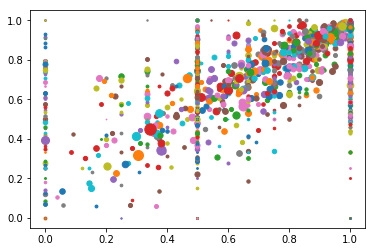

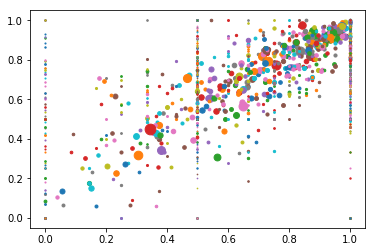

In [277]:
print(len(useful_examples.keys()))
%matplotlib inline
x=[]
y=[]
size1=[]
size2=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['ratio_edited_positive'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
    size1.append(useful_examples[appid]['num_reviews_soon_after_early_access']+1)
    size2.append(useful_examples[appid]['num_edited_from_early_access']+1)

for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=np.log(size1[i]+1))
plt.show()
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=np.log(size2[i]+1))
plt.show()

In [360]:
print(len(full_games_list))
print(len(num_reviews))

4935
4925


In [362]:


mscores=[]
dct_list=[]
for i,appid in enumerate(full_games_list,1):
    if int(appid) in num_reviews:
        dct={}
        dct['appid']=int(appid)
        dct['name']=official_app_list[int(appid)]
        dct['num_reviews']=num_reviews[int(appid)]
        dct['failed']=None
        with open(os.path.join(parent_folder,'official_appdata',str(appid)),'r') as file:
            temp_json=json.load(file)[str(appid)]['data']
        if 'achievements' in temp_json:
            dct['has_achievements']=temp_json['achievements']['total']>0
            dct['num_achievements']=temp_json['achievements']['total']
        else:
            dct['has_achievements']=False
            dct['num_achievements']=0
        if 'controller_support' in temp_json:
            dct['controller_support']=True
        else:
            dct['controller_support']=False
        if 'developers' in temp_json:
            dct['developers']=[]
            for name in temp_json['developers']:
                if len(name.strip())>0:
                    dct['developers'].append(name.strip())
        if 'developers' not in temp_json or len(dct['developers'])==0:
            dct['developers']=[str(appid)]
        if 'publishers' in temp_json:
            dct['publishers']=[]
            for name in temp_json['publishers']:
                if len(name.strip())>0:
                    dct['publishers'].append(name.strip())
        if 'publishers' not in temp_json or len(dct['publishers'])==0:
            dct['publishers']=[str(appid)]
        if 'screenshots' in temp_json:
            dct['num_screenshots']=len(temp_json['screenshots'])
        else:
            dct['num_screenshots']=0
        if 'movies' in temp_json:
            dct['num_movies']=len(temp_json['movies'])
        else:
            dct['num_movies']=0
        if 'metacritic' in temp_json:
            dct['has_metacritic']=True
            dct['metacritic_score']=temp_json['metacritic']['score']
            if(temp_json['metacritic']['score'])<72.68-9.32:
                dct['failed']=True
            else:
                dct['failed']=False
            mscores.append(temp_json['metacritic']['score'])
        else:
            dct['has_metacritic']=False
            dct['metacritic_score']=72.68
        if 'supported_languages' in temp_json:
            dct['num_languages']=len(temp_json['supported_languages'].split(','))
        else:
            dct['num_languages']=1
        if 'categories' in temp_json:
            dct['categories']=[x['description'] for x in temp_json['categories']]
        else:
            dct['categories']=[]
        if 'genres' in temp_json:
            dct['genres']=[x['description'] for x in temp_json['genres']]
        else:
            dct['genres']=[]
        if 'price_overview' not in temp_json:
            if temp_json['is_free']:
                dct['is_free']=True
            else:
                dct['is_free']=False
                dct['failed']=True
        else:
            dct['is_free']=False
        if 'platforms' in temp_json:
            dct['platforms']=0
            for platform in temp_json['platforms']:
                if temp_json['platforms'][platform]:
                    dct['platforms']+=1
        if 'platforms' not in dct or dct['platforms']==0:
            dct['platforms']=1
        if 'packages' in temp_json and len(temp_json['packages'])>1:
            dct['multiple_packages']=True
        else:
            dct['multiple_packages']=False
        if temp_json['content_descriptors']['notes'] is not None:
            dct['content_warning']=True
        else:
            dct['content_warning']=False
        if int(appid) in current_ea_games:
            dct['still_in_early_access']=True
        else:
            dct['still_in_early_access']=False
        dct_list.append(dct)
    clear_output(wait=True)
    print(str(i)+"/"+str(len(former_ea_games)))
    
    
    
    

#with open(os.path.join(parent_folder,'official_appdata',str(218980)),'r') as file:
#    temp_json=json.load(file)
        
#pprint(temp_json[str(218980)]['data'])
'''appid=264710
with open(os.path.join(parent_folder,'official_appdata',str(264710)),'r') as file:
    temp_json=json.load(file)[str(appid)]['data']
temp_json.pop('developers')
temp_json.pop('publishers')
temp_json.pop('controller_support')
temp_json.pop('screenshots')
temp_json.pop('achievements')
temp_json.pop('name')
temp_json.pop('package_groups')
temp_json.pop('pc_requirements')
temp_json.pop('recommendations')
temp_json.pop('release_date')
temp_json.pop('short_description')
temp_json.pop('support_info')
temp_json.pop('steam_appid')
temp_json.pop('type')
temp_json.pop('website')
temp_json.pop('mac_requirements')
temp_json.pop('linux_requirements')
temp_json.pop('header_image')
temp_json.pop('about_the_game')
temp_json.pop('background')
temp_json.pop('detailed_description')
temp_json.pop('metacritic')
temp_json.pop('movies')
temp_json.pop('supported_languages')
temp_json.pop('legal_notice')
temp_json.pop('categories')
temp_json.pop('genres')
temp_json.pop('price_overview')
temp_json.pop('is_free')
temp_json.pop('required_age')
temp_json.pop('platforms')
temp_json.pop('packages')
pprint(temp_json)''';

#print(str(len(mscores))+"/"+str(len(full_games_list)))
#print(min(mscores))
#print(np.std(mscores))
#print(np.mean(mscores))

#<div class="mature_content_notice">
#<h2>Mature Content Description</h2>


4935/1996


In [366]:
temp_df=pd.DataFrame(dct_list)
temp_df[temp_df['still_in_early_access']==True].head()

,appid,categories,content_warning,controller_support,developers,failed,genres,has_achievements,has_metacritic,is_free,...,multiple_packages,name,num_achievements,num_languages,num_movies,num_reviews,num_screenshots,platforms,publishers,still_in_early_access
0,15540,"[Single-player, Steam Achievements, Steam Trad...",False,False,"[Dejobaan Games, LLC]",None,"[Action, Early Access, Indie]",True,False,False,...,True,1... 2... 3... KICK IT! (Drop That Beat Like a...,1,1,1,483,10,1,"[Dejobaan Games, LLC]",True
1,16900,"[Single-player, Online Multi-Player, Online Co...",False,False,[BlackFoot Studios],None,"[Action, Indie, Early Access]",False,False,False,...,False,Ground Branch,0,1,2,591,16,1,[BlackFoot Studios],True
3,108600,"[Single-player, Multi-player, Co-op, Shared/Sp...",False,False,[The Indie Stone],None,"[Indie, RPG, Simulation, Early Access]",False,False,False,...,True,Project Zomboid,0,16,1,19407,12,3,[The Indie Stone],True
14,217120,"[Single-player, Full controller support, Steam...",False,True,[Squid In A Box Ltd],None,"[Action, Casual, Indie, Early Access]",False,False,False,...,False,Waves²,0,1,4,64,10,1,[Squid In A Box Ltd],True
20,223490,"[Single-player, Multi-player]",False,False,[ioneo],None,"[Casual, Indie, RPG, Simulation, Strategy, Ear...",False,False,False,...,False,Blockscape,0,1,1,829,6,1,[ioneo],True


In [378]:
all_categories=set()
all_genres=set()
all_developers={}
all_publishers={}

for i,row in temp_df.iterrows():
    all_categories=all_categories | set(row['categories'])
    all_genres=all_categories | set(row['genres'])
    for developer in row['developers']:
        if developer not in all_developers:
            all_developers[developer]=1
        else:
            all_developers[developer]+=1
    for publisher in row['publishers']:
        if publisher not in all_publishers:
            all_publishers[publisher]=1
        else:
            all_publishers[publisher]+=1
all_genres.remove('Early Access')
print(len(all_categories))
print(len(all_genres))
#for developer in all_developers:
#    if all_developers[developer]>1:
#        print(developer+": "+str(all_developers[developer]))

29
30
Eclipse Games: 2
Carbon Games: 3
Bohemia Interactive: 3
Stardock Entertainment: 2
Croteam: 2
Larian Studios: 2
22cans: 2
Nival: 2
Little Green Men Games: 2
Pathea Games: 2
inXile Entertainment: 2
M2H: 3
Blackmill Games: 2
Klei Entertainment: 3
Kunos Simulazioni: 2
Digitalmindsoft: 2
Keen Software House: 2
Double Fine Productions: 3
Witch Beam: 2
RuneStorm: 2
Brace Yourself Games: 2
Hashbang Games: 2
KillHouse Games: 2
Blue Bottle Games: 2
Facepunch Studios: 2
Reverie World Studios: 2
Final Boss Entertainment: 2
Iteration 11: 2
Xaviant: 2
Krome Studios: 4
Krealit: 2
Elder Games: 2
PIXOWL INC.: 2
Wastelands Interactive: 2
SmashGames: 3
Midgar Studio: 2
Spicy Tails: 2
Ranmantaru Games: 3
HB Studios: 2
Osumia Games: 2
Cryptic Sea: 2
Free Lives: 3
Spilt Milk Studios Ltd: 2
Team Jolly Roger: 2
Factus Games: 2
WRF Studios: 2
Nvizzio Creations: 3
Bit Planet Games, LLC: 2
RageSquid: 2
Schell Games: 2
BadFly Interactive, a.s.: 3
Alientrap: 4
Crafty Studios: 2
AMPLITUDE Studios: 2
Bitbox Lt

In [236]:
print(len(temp_df))
print(len(temp_df[temp_df['num_reviews']>1]))
print(temp_df[temp_df['metacritic_score']<60][['name','appid','metacritic_score']])

4925
4796
                                        name   appid  metacritic_score
24                         Clockwork Empires  224740              58.0
34                                     Dream  229580              59.0
39                   Akaneiro: Demon Hunters  230310              53.0
60                             Vector Thrust  242130              57.0
75                            Spacebase DF-9  246090              49.0
88                                    Nether  247730              57.0
136                                   Bedlam  261490              54.0
152                               Son of Nor  264000              54.0
161                      Meridian: New World  265120              43.0
167                          Worlds of Magic  265970              52.0
222                                  LA Cops  278810              45.0
227                               Soul Axiom  279900              57.0
237            Woolfe - The Red Hood Diaries  281940              5

In [169]:
print(temp_df.isna().sum())

categories               0
content_warning          0
controller_support       0
developers               0
failed                4552
genres                   0
has_achievements         0
has_metacritic           0
is_free                  0
metacritic_score         0
multiple_packages        0
num_achievements         0
num_languages            0
num_movies               0
num_reviews              0
num_screenshots          0
platforms                0
publishers               0
dtype: int64


In [381]:
testing_folder=os.path.join(parent_folder,"bulk","testing")
temp_df.to_csv(os.path.join(testing_folder,'20190124_games.csv'),index=False)

1930


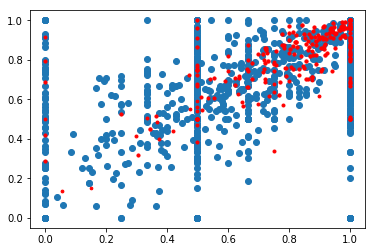

In [247]:
print(len(useful_examples.keys()))
%matplotlib inline
x1=[]
y1=[]
x2=[]
y2=[]
size=[]
for appid in useful_examples:
    if appid not in temp_df[temp_df['has_metacritic']==True].appid.unique():
        x1.append(useful_examples[appid]['ratio_edited_positive'])
        y1.append(useful_examples[appid]['ratio_soon_after_positive'])
    else:
        x2.append(useful_examples[appid]['ratio_edited_positive'])
        y2.append(useful_examples[appid]['ratio_soon_after_positive'])
        size.append(np.log(temp_df[temp_df['appid']==appid]['metacritic_score']/3))

plt.plot(x1,y1,'o')
for i in range(len(x2)):
    plt.plot(x2[i],y2[i],'o',c='r',ms=size[i])

In [340]:
time_series_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month")

for i,appid in enumerate(useful_examples,1):
    df=pd.read_csv(os.path.join(time_series_folder,str(appid)+'_month_time_series.csv'))
    df['pos_reviews']=df.apply(lambda x: x['ratio']*x['reviews'],axis=1)
    useful_examples[appid]['overall_ratio']=df.pos_reviews.sum()/df.reviews.sum()
    if df['month'][1]==1 and df['reviews'][0] < 0.5*df['reviews'][1]:
        useful_examples[appid]['original_ratio']=(df['pos_reviews'][0]+df['pos_reviews'][1])/(df['reviews'][0]+df['reviews'][1])
    else:
        useful_examples[appid]['original_ratio']=df['ratio'][0]
    release_month=df[df['early_access']==False]['month'].min()
    last_ea_month=df[df['early_access']==True]['month'].max()
    halfpoint_month=df[df['month']<(release_month/2.0)]['month'].max()
    if release_month==0:
        halfpoint_month=0
    useful_examples[appid]['releasepoint_ratio']=float(df[df['month']==last_ea_month]['pos_reviews'])/float(df[df['month']==last_ea_month]['reviews'])
    useful_examples[appid]['prerelease_ratio']=df[df['early_access']==True].pos_reviews.sum()/df[df['early_access']==True].reviews.sum()
    useful_examples[appid]['halfpoint_ratio']=float(df[df['month']==halfpoint_month]['pos_reviews'])/float(df[df['month']==halfpoint_month]['reviews'])
    useful_examples[appid]['halfrelease_ratio']=df[df['month']<(release_month/2.0)].pos_reviews.sum()/df[df['month']<(release_month/2.0)].reviews.sum()
    clear_output(wait=True)
    print(str(i)+"/"+str(len(useful_examples)))

1930/1930


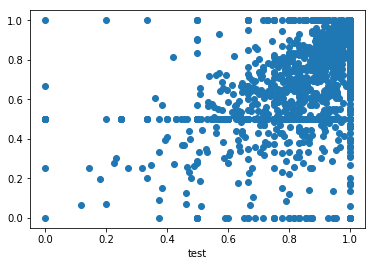

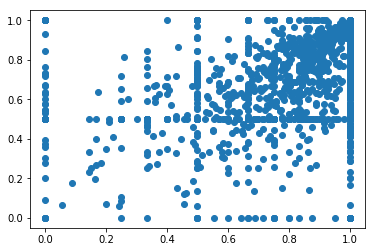

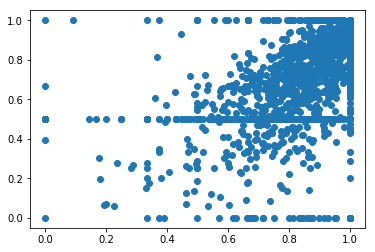

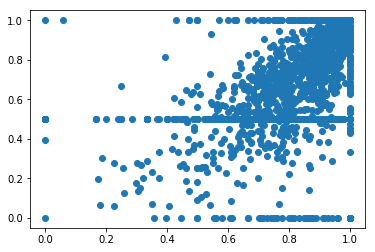

In [338]:
x=[]
y=[]
size=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['original_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
plt.plot(x,y,'o')
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['halfpoint_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
plt.plot(x,y,'o')
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['halfrelease_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
plt.plot(x,y,'o')
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['prerelease_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
plt.plot(x,y,'o')
plt.show()

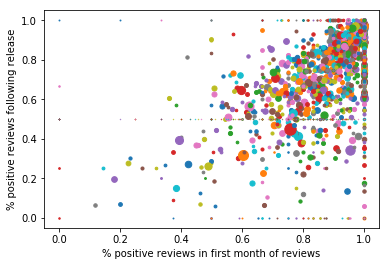

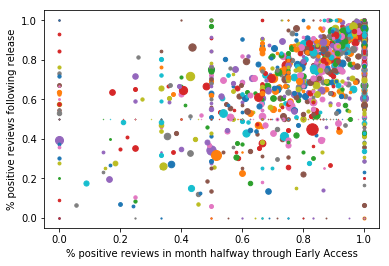

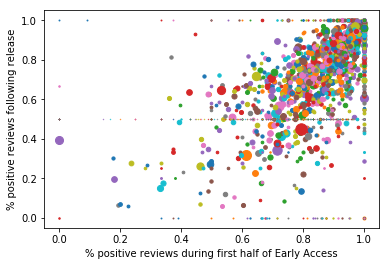

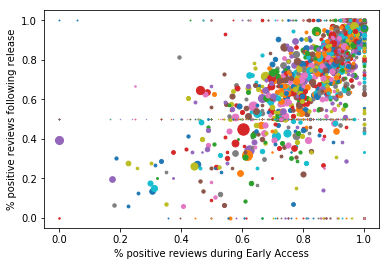

In [343]:
x=[]
y=[]
size=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['original_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
    size.append(np.log(useful_examples[appid]['num_reviews_soon_after_early_access']+1.5))
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews in first month of reviews")
plt.ylabel("% positive reviews following release")
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['halfpoint_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews in month halfway through Early Access")
plt.ylabel("% positive reviews following release")
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['halfrelease_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews during first half of Early Access")
plt.ylabel("% positive reviews following release")
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['prerelease_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive'])
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews during Early Access")
plt.ylabel("% positive reviews following release")
plt.show()

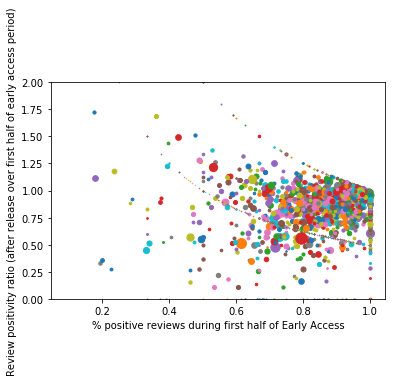

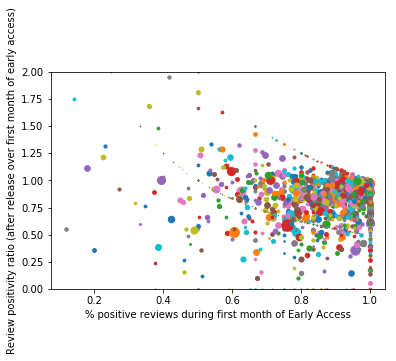

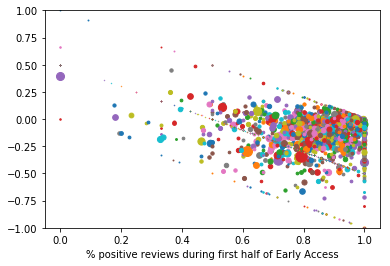

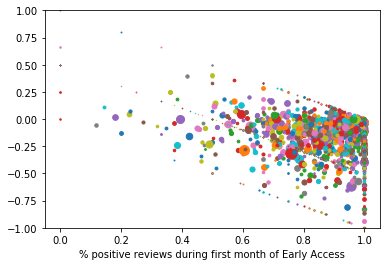

In [348]:
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['halfrelease_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive']/useful_examples[appid]['halfrelease_ratio'])
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews during first half of Early Access")
plt.ylabel("Review positivity ratio (after release over first half of early access period)")
plt.ylim(0,2)
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['original_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive']/useful_examples[appid]['original_ratio'])
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews during first month of Early Access")
plt.ylabel("Review positivity ratio (after release over first month of early access)")
plt.ylim(0,2)
plt.show()

x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['halfrelease_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive']-useful_examples[appid]['halfrelease_ratio'])
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews during first half of Early Access")
#plt.ylabel("Review positivity ratio (after release over first half of early access period)")
plt.ylim(-1,1)
plt.show()
x=[]
y=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['original_ratio'])
    y.append(useful_examples[appid]['ratio_soon_after_positive']-useful_examples[appid]['original_ratio'])
for i in range(len(x)):
    plt.plot(x[i],y[i],'o',ms=size[i])
plt.xlabel("% positive reviews during first month of Early Access")
#plt.ylabel("Review positivity ratio difference (after release over first month of early access)")
plt.ylim(-1,1)
plt.show()                

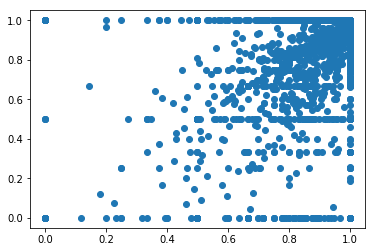

In [342]:
x=[]
y=[]
size=[]
for appid in useful_examples:
    x.append(useful_examples[appid]['original_ratio'])
    y.append(useful_examples[appid]['releasepoint_ratio'])
plt.plot(x,y,'o')
plt.show()

In [ ]:
# Make training examples of games with early access reviews, non-early access reviews, and at least
# three months between the first early access review and the first non-early access review

csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
out_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month_from_")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

early_access_exit_time={}
normal_review_start_time={}
time_midpoint={}

for i,appid in enumerate(former_ea_games,1):
    temp_time_series=[]
    df=pd.read_csv(os.path.join(csv_folder,str(appid)+'_reviews_all.csv'))
    if len(df[df['written_during_early_access']==True])>0:
        num_reviews[int(appid)]=len(df)
        early_access_exit_time[int(appid)]=df[df['written_during_early_access']==True]['timestamp_updated'].max()
        earliest_time=df['timestamp_updated'].min()
        latest_time=df['timestamp_updated'].max()
        #print(len(df[df['written_during_early_access']==True]))
        if(len(df[df['written_during_early_access']==False]))>0:
            normal_review_start_time[int(appid)]=df[df['written_during_early_access']==False]['timestamp_updated'].min()
            midpoint=(early_access_exit_time[int(appid)]+normal_review_start_time[int(appid)])/2
            num_months_after=int(np.ceil(float(latest_time-midpoint)/(30.0*24.0*60.0*60.0)))
        else:
            midpoint=early_access_exit_time[int(appid)]+60
            num_months_after=0
        time_midpoint[int(appid)]=midpoint
        #print(appid)
        #print(float(early_access_exit_time[int(appid)]))
        #print(float(normal_review_start_time[int(appid)]))
        num_months_before=int(np.ceil(float(time_midpoint[int(appid)]-earliest_time)/(30.0*24.0*60.0*60.0)))
        for j in range(num_months_before):
            num_pos=float(len(df[(df['timestamp_updated']>=midpoint-(num_months_before-j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint-(num_months_before-(j+1))*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==True)]))
            num_neg=float(len(df[(df['timestamp_updated']>=midpoint-(num_months_before-j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint-(num_months_before-(j+1))*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==False)]))
            if num_neg>0 or num_pos>0:
                temp_time_series.append({'early_access':True,'month':j,'reviews':int(num_pos+num_neg),'ratio':num_pos/(num_neg+num_pos)})
        for j in range(num_months_after):
            num_pos=float(len(df[(df['timestamp_updated']>=midpoint+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint+(j+1)*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==True)]))
            num_neg=float(len(df[(df['timestamp_updated']>=midpoint+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<midpoint+(j+1)*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==False)]))
            if num_neg>0 or num_pos>0:
                temp_time_series.append({'early_access':False,'month':num_months_before+j,'reviews':int(num_pos+num_neg),'ratio':num_pos/(num_neg+num_pos)})
        pd.DataFrame(temp_time_series).to_csv(os.path.join(out_folder,str(appid)+'_month_time_series.csv'))
    clear_output(wait=True)
    print(str(i)+"/"+str(len(former_ea_games)))

In [337]:
j=0
feature_rows=[]

def extract_month_data(month,df,vec,k):
    ms=df['month']
    if month in df.month.unique():
        vec[0][k]=int(ms[ms==])
        
for i,appid in enumerate(useful_examples,1):
    df=pd.read_csv(os.path.join(time_series_folder,str(appid)+'_month_time_series.csv'))
    #df['pos_reviews']=df.apply(lambda x: x['ratio']*x['reviews'],axis=1)
    last_ea_month=df[df['early_access']==True]['month'].max()
    for j in range(last_ea_month,2,-1):
        feature_rows.append(np.zeros((1,8)))
        feature_rows[0,0]=last_ea_month[last_ea_month==]
        #feature_rows[-1][0][0]=df[]
    
    #clear_output(wait=True)
    #print(str(i)+"/"+str(len(useful_examples)))
print("Done: "+str(j)+"/"+str(len(useful_examples)))

7    7
Name: month, dtype: int64
7
7    7
Name: month, dtype: int64
7
6    7
Name: month, dtype: int64
7
7    7
Name: month, dtype: int64
7
7    7
Name: month, dtype: int64
7
7    7
Name: month, dtype: int64
7
7    7
Name: month, dtype: int64
7
7    7
Name: month, dtype: int64
7
7    7
Name: month, dtype: int64
7
Series([], Name: month, dtype: int64)


TypeError: cannot convert the series to <class 'int'>

In [358]:

x=[]
y=[]
for appid in useful_examples:
    if useful_examples[appid]['original_ratio'] >0.5:
        x.append(useful_examples[appid]['original_ratio'])
        y.append(useful_examples[appid]['ratio_soon_after_positive']/useful_examples[appid]['original_ratio'])
print(np.mean(y))
print(np.std(y))

0.7172828275684046
0.25978298559147395
